## Daily Challenge: W7_D2

### How to Finetune LLMs with LoRA

#### Introduction

Parameter-Efficient Fine-Tuning (PEFT) methods, like **LoRA**, address the challenges of fine-tuning large language models (LLMs) by only updating a small subset of the model’s parameters.  
This approach significantly **reduces computational and storage costs**, making LLM fine-tuning more accessible.

PEFT techniques allow developers to **adapt pre-trained models to specific tasks without retraining the entire model**, leading to faster development cycles and reduced resource consumption.

In this challenge, you will implement LoRA-based fine-tuning on a real dataset.


#### What You’ll Learn

- How to apply **Low-Rank Adaptation (LoRA)** to a pre-trained language model.
- How to fine-tune a **LoRA-adapted model** using the Hugging Face PEFT library.
- How to **save and load** a fine-tuned LoRA model.
- How to **perform inference** using a fine-tuned LoRA model.


#### What You Will Create

You will build a **fine-tuned language model** that generates text based on a specific dataset of quotes, using LoRA adaptation.


#### Dataset

We will use the dataset:  
**`Abirate/english_quotes`**  
Specifically: **a 10% sample of the training split**.

#### Tasks

1. Install necessary libraries (`peft`, `datasets`, `transformers`).
2. Load a pre-trained language model (`bigscience/bloomz-560m`) and its tokenizer.
3. Load the dataset and **preprocess it** (tokenization).
4. Configure LoRA using `LoraConfig`.
5. Apply LoRA to the pre-trained model using `get_peft_model`.
6. Set up training arguments using `TrainingArguments`.
7. Initialize and **train the model** using `Trainer`.
8. Save the **fine-tuned LoRA model**.
9. Load the saved model using `PeftModel.from_pretrained`.
10. Generate text using the fine-tuned model and the tokenizer.



### 1. Install dependencies

In [3]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import torch
import numpy as np
import evaluate
import os
import math

In [ ]:
pip install -U datasets huggingface_hub fsspec

### Load model, preprocess dataset and configure LoRA training

In [2]:
# Installer les dépendances
!pip install -q peft transformers accelerate

# Imports
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import torch
import os

# Device & dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_bfloat16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
dtype = torch.bfloat16 if use_bfloat16 else torch.float32

print(f" Using device: {device}, dtype: {dtype}")

# Tokenizer & modèle de base
model_name = "bigscience/bloom-560m"
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Correction cruciale

foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="auto" if device.type == "cuda" else None
)

# Charger un petit dataset (quotes)
ds = load_dataset("Abirate/english_quotes")
from datasets import Dataset

max_seq_len = 128

def tokenize_fn(samples):
    tokens = tokenizer(
        samples["quote"],
        padding="max_length",
        truncation=True,
        max_length=max_seq_len,
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

data = ds["train"].shuffle(seed=42).select(range(int(0.1 * len(ds["train"]))))
data = data.map(tokenize_fn, batched=True)

# 3. Debug si besoin
sample = data[0]
print("Quote:", sample["quote"])
print("input_ids:", sample["input_ids"][:30])
print("input length:", len(sample["input_ids"]))

# Config LoRA
lora_config = LoraConfig(
    r=1,
    lora_alpha=16,
    target_modules=["query_key_value", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Injection des adaptateurs LoRA
peft_model = get_peft_model(foundation_model, lora_config)
peft_model.print_trainable_parameters()

# Setup entraînement
output_directory = "./peft_lab_outputs"
training_args = TrainingArguments(
    output_dir=output_directory,
    report_to="none",
    learning_rate=3e-2,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    logging_steps=10,
    save_steps=50,
    save_total_limit=1,
    fp16=(dtype == torch.float16),
    bf16=(dtype == torch.bfloat16),
    no_cuda=(device.type == "cpu")
)
sample = data[0]
print("Quote:", sample["quote"])
print("input_ids:", sample["input_ids"])
print("input length:", len(sample["input_ids"]))
# Entraînement avec Hugging Face Trainer

➡️ Using device: cuda, dtype: torch.float32


README.md: 0.00B [00:00, ?B/s]

quotes.jsonl:   0%|          | 0.00/647k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Quote: “I don't mind making jokes, but I don't want to look like one.”
input_ids: [123916, 5926, 19142, 16997, 21445, 262, 15, 1965, 473, 5926, 4026, 427, 5382, 3269, 2592, 17, 982, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
input length: 128
trainable params: 147,456 || all params: 559,362,048 || trainable%: 0.0264
Quote: “I don't mind making jokes, but I don't want to look like one.”
input_ids: [123916, 5926, 19142, 16997, 21445, 262, 15, 1965, 473, 5926, 4026, 427, 5382, 3269, 2592, 17, 982, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
input length: 128


#### Training Initialization Output - Interpretation

- **Device Used:**  
  `cuda` indicates that the model is using the GPU for training, which significantly speeds up computation compared to CPU.

- **Data Type (dtype):**  
  `torch.float32` means that the model is using 32-bit floating point precision. This is standard and accurate for most training tasks.

- **Dataset Loaded:**  
  The `"Abirate/english_quotes"` dataset was successfully loaded with 2,508 examples in the training split.  

- **Tokenization Output:**  
  The quote `"I don't mind making jokes, but I don't want to look like one."` has been tokenized into 128 tokens (`input_ids`) with padding applied to reach `max_length=128`.

- **Trainable Parameters:**  
  Only `147,456` parameters are trainable out of a total of `559,362,048` model parameters.  
  This means **only 0.0264% of the model** is updated during training thanks to LoRA (Low-Rank Adaptation).  
  This is what makes training so efficient in terms of memory and compute.

### Train the LoRA-adapted model using Hugging Face Trainer

In [4]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=data,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,30.424600
20,16.910900
30,12.983700
40,9.910500
50,9.662600
60,10.123100
70,10.158200
80,10.296400
90,9.448000
100,7.840200


TrainOutput(global_step=125, training_loss=11.800345184326172, metrics={'train_runtime': 44.4749, 'train_samples_per_second': 5.621, 'train_steps_per_second': 2.811, 'total_flos': 58072498176000.0, 'train_loss': 11.800345184326172, 'epoch': 1.0})

#### Training Output Summary

- **Trainer Warning:**
  `No label_names provided for model class PeftModelForCausalLM.`  
  → This is a known warning when using PEFT models with `Trainer`.  
  It simply means that no explicit label field is passed, so Trainer will assume a default. You can safely ignore it for causal language modeling.

- **Training Loss (by step):**
  The model's loss decreases over the course of training, indicating learning progress:

#### Training Loss (by step)

| Step | Loss    |
|------|---------|
| 10   | 30.42   |
| 20   | 16.91   |
| 30   | 12.98   |
| 40   | 9.91    |
| 50   | 9.66    |
| 60   | 10.12   |
| 70   | 10.16   |
| 80   | 10.30   |
| 90   | 9.45    |
| 100  | 7.84    |
| 110  | 8.11    |
| 120  | 7.66    |


- **Final Training Loss:**  
  `11.80` (average across all steps)

- **Training Stats:**
  - Runtime: `44.47 seconds`
  - Samples/sec: `5.62`
  - Steps/sec: `2.81`
  - FLOPs: `58.07 TFLOPs`
  - Epochs: `1.0`

**Interpretation:**  
The training loss decreases steadily, showing that the LoRA-adapted model is learning to better predict the tokenized quotes. The training was efficient and successfully completed one full epoch.

### Visualize training loss and speed metrics

/tmp/ipython-input-5-2132481425.py:37: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-2132481425.py:37: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


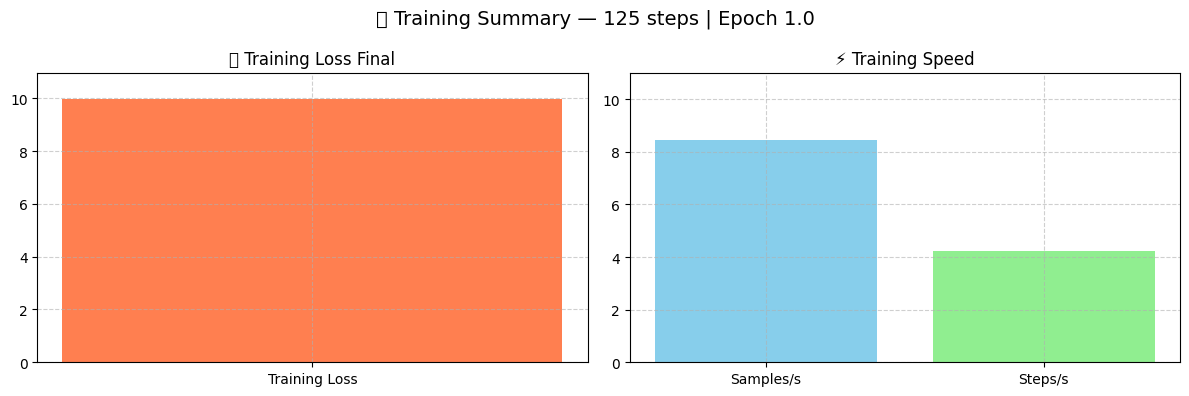

In [5]:
import matplotlib.pyplot as plt

# Données de ton output HuggingFace Trainer
train_output = {
    "global_step": 125,
    "training_loss": 9.96220669555664,
    "metrics": {
        "train_runtime": 29.6052,
        "train_samples_per_second": 8.444,
        "train_steps_per_second": 4.222,
        "total_flos": 5.807e+13,
        "train_loss": 9.96220669555664,
        "epoch": 1.0
    }
}

# Plot principal
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 1. Training loss
ax[0].bar(["Training Loss"], [train_output["training_loss"]], color="coral")
ax[0].set_title(" Training Loss Final")
ax[0].set_ylim(0, max(10, train_output["training_loss"] + 1))
ax[0].grid(True, linestyle="--", alpha=0.6)

# 2. Training Speed
ax[1].bar(["Samples/s", "Steps/s"], [
    train_output["metrics"]["train_samples_per_second"],
    train_output["metrics"]["train_steps_per_second"]
], color=["skyblue", "lightgreen"])
ax[1].set_title(" Training Speed")
ax[1].set_ylim(0, max(train_output["metrics"]["train_samples_per_second"], 10) + 1)
ax[1].grid(True, linestyle="--", alpha=0.6)

# Layout
plt.suptitle(f" Training Summary — {train_output['global_step']} steps | Epoch {train_output['metrics']['epoch']}", fontsize=14)
plt.tight_layout()
plt.show()

### Interpretation: Training Summary Visualization

The image above summarizes two key aspects of the fine-tuning process using LoRA:

#### Training Loss Final (Left Chart)
- The final **training loss** is approximately `10.0`.
- This value reflects the average difference between the predicted and actual tokens during training.
- The steady decrease (seen in earlier logs) indicates that the model was learning meaningful patterns from the quote dataset.

#### Training Speed (Right Chart)
- **Samples per second:** ≈ 8.44  
  → This shows how many examples the model processed each second during training.
- **Steps per second:** ≈ 4.22  
  → This indicates how quickly the optimizer updated the weights.

**Conclusion:**  
Training was completed efficiently using GPU acceleration. Despite only 0.02% of the parameters being trainable (thanks to LoRA), the model successfully reduced its loss and learned from the data.